In [1]:
%pylab inline
from matplotlib import ticker
import os,sys
sys.path.append('../bok')
from astropy.table import Table,join
from astropy.stats import sigma_clip
import bokrmphot
_ = os.environ.setdefault('BOKRMDIR','../bok')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_pstable(psTabFn,photRun=None,season='2014'):
    if not os.path.exists(psTabFn):
        psTab = bokrmphot.binned_phot_stats(photRun,season=season)
        psTab.write(psTabFn)
    psTab = Table.read(psTabFn)
    for c in psTab.colnames:
        if c.startswith('sig'):
            psTab[c].format = "{:.4f}"
        elif c=='outlierFrac':
            psTab[c].format = "{:.5f}"
    return psTab

In [3]:
psNov2015g = load_pstable('../phot_stats_Nov2015g.fits')
print psNov2015g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0174    0.0144     0.00179
 17.2 0.0207    0.0162     0.00156
 17.4 0.0237    0.0172     0.00162
 17.6 0.0194    0.0170     0.00135
 17.8 0.0217    0.0177     0.00133
 18.0 0.0289    0.0193     0.00183
 18.2 0.0275    0.0207     0.00174
 18.4 0.0300    0.0238     0.00150
 18.6 0.0295    0.0239     0.00136
 18.8 0.0337    0.0279     0.00175
 19.0 0.0380    0.0318     0.00176


In [4]:
psJan2017g = load_pstable('../phot_stats_Jan2017g.fits')
print psJan2017g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0106    0.0106     0.00003
 17.2 0.0110    0.0110     0.00018
 17.4 0.0114    0.0114     0.00004
 17.6 0.0120    0.0120     0.00019
 17.8 0.0120    0.0119     0.00012
 18.0 0.0134    0.0134     0.00012
 18.2 0.0142    0.0141     0.00016
 18.4 0.0155    0.0154     0.00017
 18.6 0.0178    0.0178     0.00017
 18.8 0.0197    0.0195     0.00028
 19.0 0.0229    0.0229     0.00022


In [5]:
psFeb2017g = load_pstable('../phot_stats_Feb2017g.fits')
print psFeb2017g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0107    0.0107     0.00000
 17.2 0.0112    0.0112     0.00006
 17.4 0.0115    0.0115     0.00000
 17.6 0.0118    0.0118     0.00010
 17.8 0.0121    0.0120     0.00011
 18.0 0.0133    0.0133     0.00011
 18.2 0.0142    0.0142     0.00012
 18.4 0.0156    0.0156     0.00011
 18.6 0.0178    0.0178     0.00016
 18.8 0.0195    0.0194     0.00026
 19.0 0.0228    0.0227     0.00017


In [6]:
psJan2017i = load_pstable('../phot_stats_Jan2017i.fits')
print psJan2017i['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0201    0.0201     0.00002
 17.2 0.0201    0.0201     0.00004
 17.4 0.0207    0.0207     0.00001
 17.6 0.0213    0.0213     0.00001
 17.8 0.0221    0.0221     0.00006
 18.0 0.0231    0.0231     0.00000
 18.2 0.0247    0.0247     0.00004
 18.4 0.0268    0.0267     0.00008
 18.6 0.0294    0.0294     0.00003
 18.8 0.0322    0.0322     0.00005
 19.0 0.0366    0.0366     0.00007


In [7]:
psFeb2017i = load_pstable('../phot_stats_Feb2017i.fits')
print psFeb2017i['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0190    0.0190     0.00080
 17.2 0.0192    0.0192     0.00077
 17.4 0.0196    0.0195     0.00080
 17.6 0.0205    0.0203     0.00076
 17.8 0.0212    0.0212     0.00070
 18.0 0.0225    0.0224     0.00074
 18.2 0.0243    0.0240     0.00086
 18.4 0.0264    0.0261     0.00076
 18.6 0.0290    0.0287     0.00073
 18.8 0.0320    0.0317     0.00073
 19.0 0.0367    0.0361     0.00064


In [13]:
def plot_compare_scatters(psTabs,labels,colors='rgbcymk',filt='g'):
    def _append_arr(arr):
        return arr
        # used this for drawstyle=steps-post, but no equiv. for fill_between
        #return np.concatenate([arr,[arr[-1]]])
    figure()
    for tab,l,c in zip(psTabs,labels,colors):
        fill_between(tab['mbins'],_append_arr(tab['sig25Clip']),
                     _append_arr(tab['sig75Clip']),
                     edgecolor='none',color=c,alpha=0.5)
        plot(tab['mbins'],_append_arr(tab['sig50Clip']),color=c,lw=1.5,label=l)
    legend(loc='upper left')
    xlabel('%s magnitude' % filt)
    ylabel('per-object std [mag]')
    xlim(17,19)

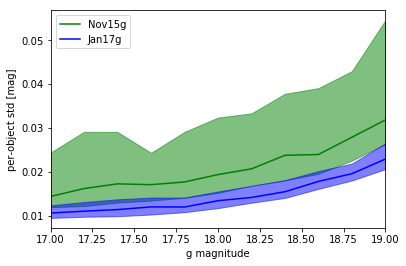

In [9]:
plot_compare_scatters([psNov2015g,psJan2017g],['Nov15g','Jan17g'],'gb')

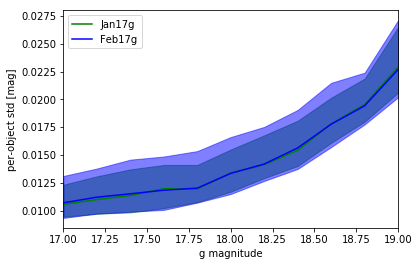

In [10]:
plot_compare_scatters([psJan2017g,psFeb2017g],['Jan17g','Feb17g'],'gb')

The scatter increases significantly if fainter stars are included in the zeropoint. Going from mag$<19.5$ to mag$<20.5$ more than doubles the scatter. Do not understand why this is...

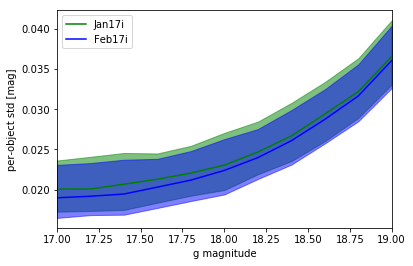

In [11]:
plot_compare_scatters([psJan2017i,psFeb2017i],['Jan17i','Feb17i'],'gb')

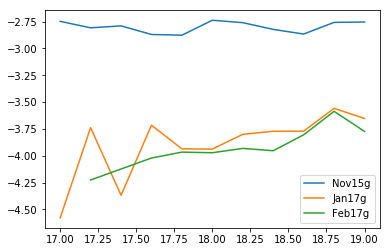

In [14]:
for psTab,l in zip([psNov2015g,psJan2017g,psFeb2017g],['Nov15g','Jan17g','Feb17g']):
    ii = where(psTab['outlierFrac']>0)[0]
    plot(psTab['mbins'][ii],log10(psTab['outlierFrac'][ii]),label=l)
legend()

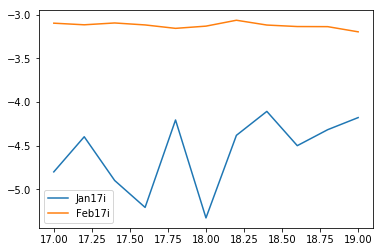

In [15]:
for psTab,l in zip([psJan2017i,psFeb2017i],['Jan17i','Feb17i']):
    ii = where(psTab['outlierFrac']>0)[0]
    plot(psTab['mbins'][ii],log10(psTab['outlierFrac'][ii]),label=l)
legend()

# 2015/6 data

In [10]:
ps2015g = load_pstable('phot_stats_2015g.fits','cleanstars','2015')
print ps2015g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0170    0.0168     0.00037
 17.2 0.0165    0.0164     0.00035
 17.4 0.0177    0.0174     0.00065
 17.6 0.0183    0.0182     0.00051
 17.8 0.0186    0.0184     0.00047
 18.0 0.0197    0.0196     0.00035
 18.2 0.0212    0.0210     0.00037
 18.4 0.0230    0.0228     0.00031
 18.6 0.0259    0.0257     0.00036
 18.8 0.0287    0.0286     0.00044
 19.0 0.0334    0.0332     0.00045


In [11]:
ps2016g = load_pstable('phot_stats_2016g.fits','cleanstars','2016')
print ps2016g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0164    0.0163     0.00028
 17.2 0.0163    0.0163     0.00026
 17.4 0.0167    0.0166     0.00056
 17.6 0.0171    0.0171     0.00042
 17.8 0.0176    0.0174     0.00040
 18.0 0.0184    0.0183     0.00033
 18.2 0.0199    0.0198     0.00029
 18.4 0.0214    0.0213     0.00037
 18.6 0.0240    0.0240     0.00028
 18.8 0.0262    0.0260     0.00065
 19.0 0.0307    0.0302     0.00048


In [9]:
ps2014g = load_pstable('phot_stats_2014g.fits','cleanstars','2014')
print ps2014g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0116    0.0116     0.00000
 17.2 0.0125    0.0125     0.00014
 17.4 0.0126    0.0126     0.00008
 17.6 0.0131    0.0130     0.00011
 17.8 0.0133    0.0133     0.00009
 18.0 0.0144    0.0144     0.00008
 18.2 0.0155    0.0154     0.00013
 18.4 0.0169    0.0169     0.00013
 18.6 0.0189    0.0188     0.00019
 18.8 0.0209    0.0209     0.00030
 19.0 0.0244    0.0242     0.00031


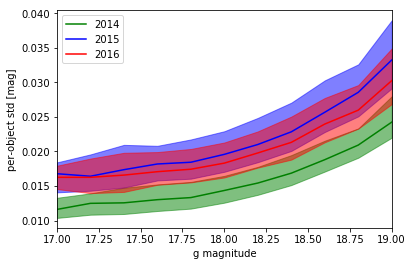

In [14]:
plot_compare_scatters([ps2014g,ps2015g,ps2016g],['2014','2015','2016'],'gbr')